### Setting stuff up

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/cryptooo/notebooks

/content/drive/MyDrive/cryptooo/notebooks


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 15.6 MB 41.9 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 198 kB 47.5 MB/s 
     |████████████████████████████████| 79 kB 3.1 MB/s 
     |████████████████████████████████| 58 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 146 kB 54.0 MB/s 
     |████████████████████████████████| 180 kB 45.6 MB/s 
     |████████████████████████████████| 210 kB 50.9 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=23bf8c55ae33b0c5b49bb7c8feeb43b64592d6059c7907bcd3de12e30ee5da65
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e

In [5]:
# Loading in code from crypto_tools
import json
from itertools import chain

foo=json.load(open("/content/drive/MyDrive/cryptooo/notebooks/crypto_tools"))
toolstr=''.join(chain(*[tmp['source'] for tmp in foo['cells'] if tmp['cell_type']=='code']))
exec(toolstr)

Connected to the CoinBase Pro API.
Found 242 instances containing the term USD.
Extended Output is False, returning reduced dataset.


2022-02-14 05:13:28.877 | INFO     | __main__:<module>:54 - Created pbtc and dbtc
2022-02-14 05:13:30.329 | INFO     | __main__:<module>:54 - Created peth and deth
2022-02-14 05:13:31.378 | INFO     | __main__:<module>:54 - Created pltc and dltc


In [6]:
peth.tail(10)

,time,low,high,open,close,volume
9749,2021-09-11 08:00:00,3221.36,3263.57,3248.10,3253.27,3588.181682
9750,2021-09-11 09:00:00,3219.19,3280.81,3252.90,3278.75,4116.186962
9751,2021-09-11 10:00:00,3267.08,3317.07,3278.59,3308.01,5058.415598
9752,2021-09-11 11:00:00,3281.50,3312.38,3308.26,3293.06,4748.338310
9753,2021-09-11 12:00:00,3283.64,3344.34,3293.87,3318.40,5302.476091
9754,2021-09-11 13:00:00,3299.01,3333.98,3318.11,3323.58,4351.724024
9755,2021-09-11 14:00:00,3317.32,3349.43,3323.37,3328.05,5840.173211
9756,2021-09-11 15:00:00,3303.58,3328.95,3327.81,3312.46,4596.715672
9757,2021-09-11 16:00:00,3282.95,3342.00,3312.27,3327.33,6899.996930
9758,2021-09-11 17:00:00,3308.44,3344.16,3327.18,3318.15,4815.395502


In [7]:
peth.shape

(9759, 6)

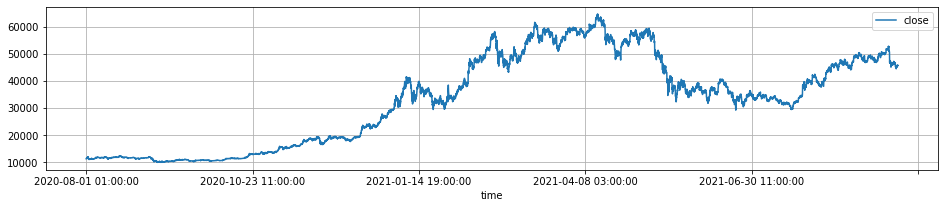

In [8]:
pl.figure(figsize=(16,3))
pbtc.plot(y='close',x="time",ax=pl.gca())
pl.gca().grid(True)
display(pl.gca())

### Exploratory models

##### Local setup

In [83]:
from pyspark.ml.linalg import Vectors,Vectors,VectorUDT
from pyspark.ml.regression import LinearRegression,LinearRegressionModel
from pyspark.sql.types  import StringType
import datetime as dt
import pylab as pl

to_vec=F.udf(lambda x:Vectors.dense(x),VectorUDT())

def ar_traindat(indf,win_len=10,feat_col="features",pred_col="open"):

  x=(indf.withColumn(feat_col,F.collect_list(pred_col)
  .over(Window.orderBy("time").rowsBetween(-win_len,-1)))
  .where(f"cardinality({feat_col})={win_len}")
  .withColumn(feat_col,to_vec(feat_col))
  .alias("dbtc").selectExpr("dbtc.*",f"{pred_col} as label"))

  return x

def addHour(timestr,hrs):

  fmtstr="%Y-%m-%d %H:%M:%S"
  return dt.datetime.strftime(dt.datetime.strptime(timestr,fmtstr)+dt.timedelta(hours=hrs),fmtstr)

addHour_udf = F.udf(lambda x,hrs:addHour(x,hrs),StringType())

def get_xpred(lrmod,xtest,safety_margin=0.02):
  xpred=(lrmod.transform(xtest)
  .join(xtest.selectExpr("time","open as open_next").
        withColumn("time",addHour_udf("time",F.lit(-1))),"time")
  .withColumn("return",F.when(F.expr(f"prediction<(open*{1-safety_margin})"),F.expr("open_next-open"))
  .when(F.expr(f"prediction>(open*{1+safety_margin})"),F.expr("open-open_next")).otherwise(F.lit(0))))

  return xpred

##### Modeling

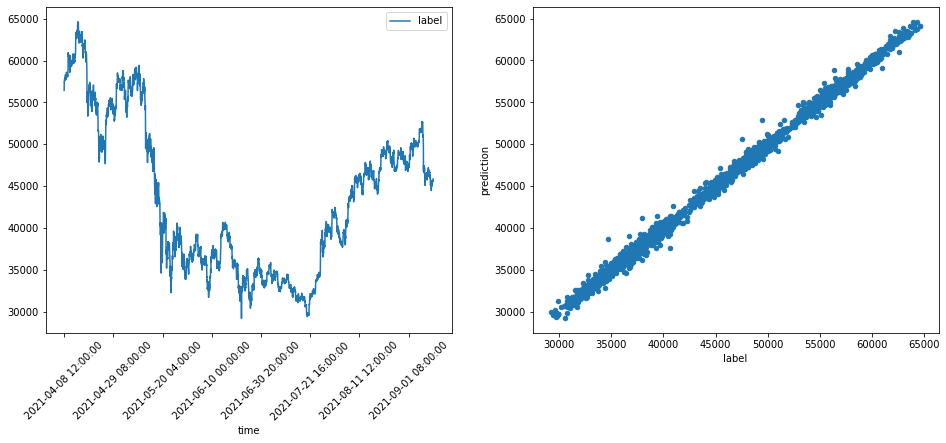

In [85]:
#@title Training on opening price

x=(ar_traindat(dbtc,10)#.select("features","label","time")
.withColumn('cnt',F.rank().over(Window.orderBy("time"))))

xtrain=x.where("cnt<6000")
xtest=x.where("cnt>=6000")

lrmod=LinearRegression().fit(xtrain)

# Sanity check
pl.figure(figsize=(16,6))

pl.subplot(1,2,1)
xtest.toPandas().plot(x='time',y='label',rot=45,ax=pl.gca())

pl.subplot(1,2,2)
lrmod.transform(xtest).select("label","prediction").toPandas().plot(x='label',y='prediction',kind='scatter',ax=pl.gca())

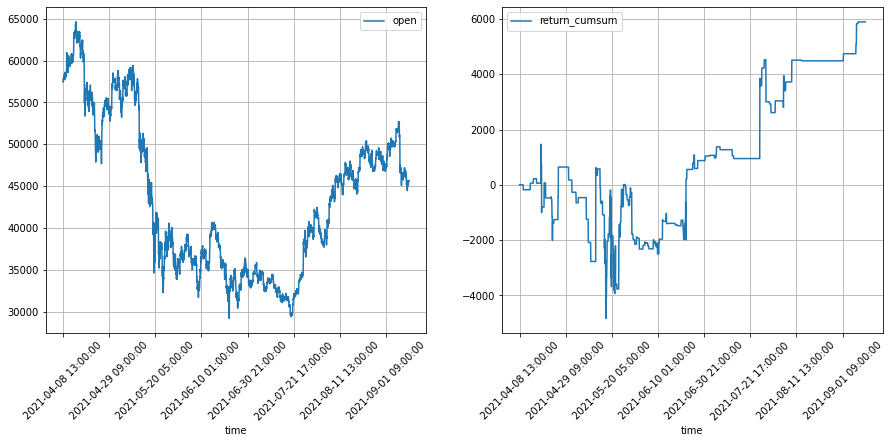

In [84]:
#@title Predicting and calculating returns for 2% safety margin

xpred=get_xpred(lrmod,xtest)

# Visualization
pf=xpred.select("time","open","return").toPandas().iloc[1:,:]
pf['return_cumsum']=pf['return'].cumsum()

pl.figure(figsize=(15,6))

pl.subplot(1,2,1)
pf.plot(x="time",y="open",rot=45, ax=pl.gca())
pl.gca().grid(True)

pl.subplot(1,2,2)
pf.plot(x="time",y="return_cumsum",rot=45, ax=pl.gca())
pl.gca().grid(True)


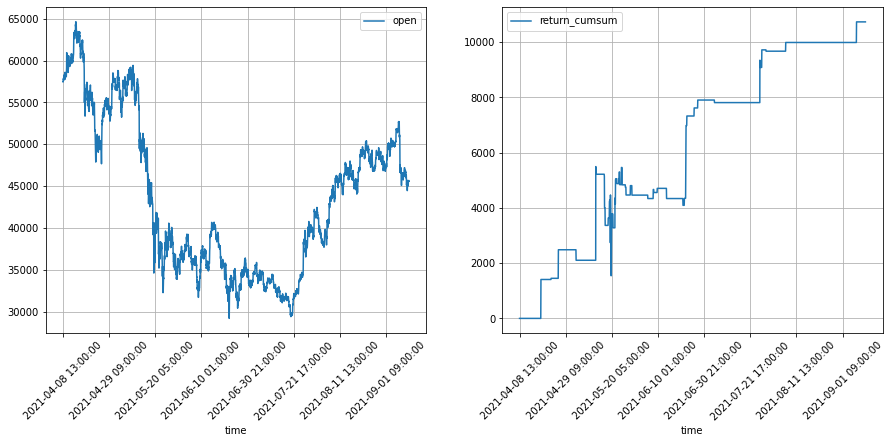

In [86]:
#@title Predicting and calculating returns for 3% safety margin

xpred=get_xpred(lrmod,xtest,safety_margin=0.03)

# Visualization
pf=xpred.select("time","open","return").toPandas().iloc[1:,:]
pf['return_cumsum']=pf['return'].cumsum()

pl.figure(figsize=(15,6))

pl.subplot(1,2,1)
pf.plot(x="time",y="open",rot=45, ax=pl.gca())
pl.gca().grid(True)

pl.subplot(1,2,2)
pf.plot(x="time",y="return_cumsum",rot=45, ax=pl.gca())
pl.gca().grid(True)
